In [2]:
from plotting import *
from CVZ import *
from JWST_SNR import compute_transmission_SNR
%matplotlib inline
# get simulation
self = loadpickle('pickles/RVInformationGP_Nrvge10_wnoisefloor')

# modify results with new noise floor using Eq 17
RVfloor = 0  # m/s
sigeff_2 = (self.sigmaRV_eff_med_N**2 + RVfloor**2) / self.sigmaRV_eff_med_N**2
self.NrvGPs_med_N *= sigeff_2
self.tobsGPs_med_N *= sigeff_2

# add overheads
overhead_sec = 30.
self.tobsGPs_med_N += self.NrvGPs_med_N * overhead_sec / (60*60)

In [3]:
# write function that returns indices of planets of interest based on their median observing times 
def get_planets(tobs, g, N=0, sort=True):
    tobsinds = np.argsort(tobs[g]) if sort else np.arange(tobs[g].size)
    inds = np.arange(tobs.size)[g][tobsinds]
    return inds if N == 0 else inds[:int(N)]

In [4]:
# get K2 targets
fname = 'input_data/K2planets_Kdwarfs.csv'
starname, planetname = np.genfromtxt(fname,delimiter=',',skip_header=75,usecols=(1,2),dtype='str').T
starnames = np.array(['%s%s'%(starname[i], planetname[i]) for i in range(starname.size)])
PK2,aK2,rpK2,TeffK2,MsK2,RsK2,JK2 = np.genfromtxt(fname,delimiter=',',skip_header=75,usecols=(5,9,25,45,49,53,61)).T
assert PK2.size == starnames.size
aK2[np.isnan(aK2)] = rvs.semimajoraxis(PK2, MsK2, 0)[np.isnan(aK2)]
rpK2 *= 11.21
TpK2 = TeffK2 * np.sqrt(rvs.Rsun2m(RsK2)/(2*rvs.AU2m(aK2)))
muK2 = np.repeat(2, TpK2.size)
muK2[rpK2 <= 2] = 30.
mpK2 = rvs.kg2Mearth(9.8*rvs.Rearth2m(rpK2)**2 / 6.67e-11)
transmissionK2_ppm = rvs.transmission_spectroscopy_depth(RsK2, mpK2, rpK2, TpK2, muK2)

## Measuring the 3$\sigma$ mass of one temperate Earth-sized planet

In [5]:
ind = 1451
inds = np.array([ind])
print 'Orbital period = %.3f days'%self.Ps_med[ind]
print 'Planet radius = %.3f Earth radii'%self.rps_med[ind]
print 'Planet mass = %.3f Earth masses'%self.mps_med[ind]
print 'J = %.3f'%self.Jmags_med[ind]
print 'Stellar effective temperature = %i K'%self.Teffs_med[ind]

Orbital period = 26.300 days
Planet radius = 1.292 Earth radii
Planet mass = 2.660 Earth masses
J = 10.270
Stellar effective temperature = 3284 K


In [6]:
print 'Exposure time = %.2f minutes'%self.texps_med_N[ind]
print 'RV precision = %.2f m/s'%self.sigmaRV_phot_med_N[ind]
print 'Median effective RV rms = %.2f m/s'%self.sigmaRV_eff_med_N[ind]
print 'Median number of RV measurements required = %.1f'%self.NrvGPs_med_N[ind]
print 'Total observing time = %.1f hours (i.e. %.1f nights)'%(self.tobsGPs_med_N[ind], self.tobsGPs_med_N[ind]/7.)
tobs_WP2 = self.tobsGPs_med_N[ind]

Exposure time = 10.00 minutes
RV precision = 2.98 m/s
Median effective RV rms = 7.86 m/s
Median number of RV measurements required = 252.8
Total observing time = 44.2 hours (i.e. 6.3 nights)


## Measuring the 5$\sigma$ mass of the 30 'best' planets within the radius valley

((0, 57.142857142857146), <matplotlib.text.Text at 0x1a19192290>)

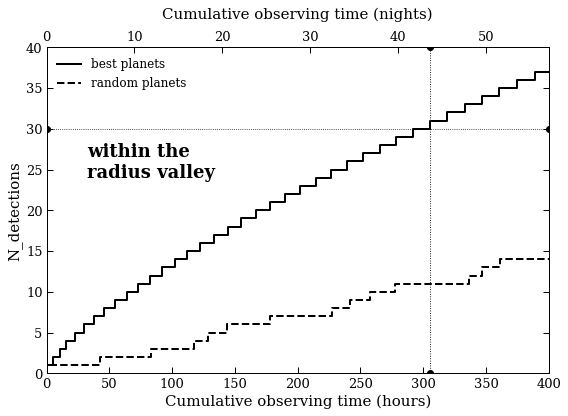

In [7]:
Nf1 = 30
scale = (.327/.189)**2  # 3 -> 5 sigma
g = (self.rps_med >= 1.5) & (self.rps_med <= 2.5) & (self.decs_med > -15)
tobs = np.append(0, np.cumsum(np.sort(self.tobsGPs_med_N[g]*scale)))
tobs2 = np.append(0, np.cumsum(self.tobsGPs_med_N[g]*scale))
Ndet= np.arange(tobs.size)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.plot(tobs, Ndet, 'k-', lw=2, drawstyle='steps', label='best planets')
ax1.plot(tobs2, Ndet, 'k--', lw=2, drawstyle='steps', label='random planets')
ax1.axhline(Nf1, ls=':', lw=.8), ax1.axvline(tobs[Ndet==Nf1], ls=':', lw=.9)
tobs_WP2 = np.append(tobs_WP2, tobs[Ndet==Nf1])
ax1.set_xlim((0,4e2)), ax1.set_ylim((0,40)), ax1.legend(loc='upper left', fontsize=12)
ax1.set_xlabel('Cumulative observing time (hours)'), ax1.set_ylabel('N_detections')
ax1.text(.08, .6, 'within the\nradius valley', transform=ax1.transAxes, fontsize=18, weight='semibold')
ax2 = ax1.twiny()
ax2.set_xlim((0,4e2/7)), ax2.set_xlabel('Cumulative observing time (nights)', labelpad=12)

In [8]:
# save TOI indices
inds = np.append(inds, get_planets(self.tobsGPs_med_N, g, Nf1))

## Extending the MR relation with 10 planets with $r_p \in [2.5,4] R_{\oplus}$

((0, 28.571428571428573), <matplotlib.text.Text at 0x1a176a9b10>)

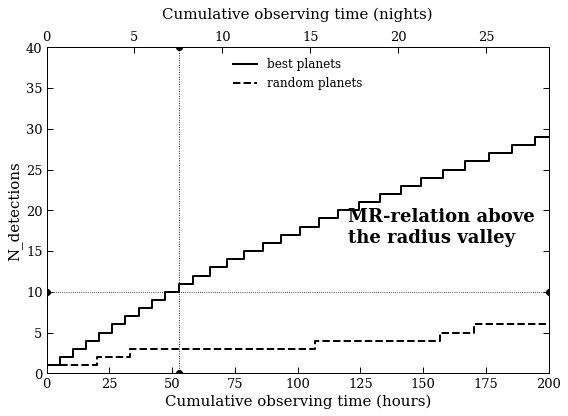

In [9]:
Nf2 = 10 
g = (self.rps_med > 2.5) & (self.rps_med <= 4) & (self.decs_med > -15)
tobs = np.append(0, np.cumsum(np.sort(self.tobsGPs_med_N[g]*scale)))
tobs2 = np.append(0, np.cumsum(self.tobsGPs_med_N[g]*scale))
Ndet= np.arange(tobs.size)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.plot(tobs, Ndet, 'k-', lw=2, drawstyle='steps', label='best planets')
ax1.plot(tobs2, Ndet, 'k--', lw=2, drawstyle='steps', label='random planets')
ax1.axhline(Nf2, ls=':', lw=.8), ax1.axvline(tobs[Ndet==Nf2], ls=':', lw=.9)
tobs_WP2 = np.append(tobs_WP2, tobs[Ndet==Nf2])
ax1.set_xlim((0,2e2)), ax1.set_ylim((0,40)), ax1.legend(loc='upper center', fontsize=12)
ax1.set_xlabel('Cumulative observing time (hours)'), ax1.set_ylabel('N_detections')
ax1.text(.6, .4, 'MR-relation above\nthe radius valley', transform=ax1.transAxes, fontsize=18, weight='semibold')
ax2 = ax1.twiny()
ax2.set_xlim((0,2e2/7)), ax2.set_xlabel('Cumulative observing time (nights)', labelpad=12)

In [10]:
inds = np.append(inds, get_planets(self.tobsGPs_med_N, g, Nf2))

## Extending the MR relation with 10 more planets with $r_p < 1.5 R_{\oplus}$

((0, 28.571428571428573), <matplotlib.text.Text at 0x1a159f3b10>)

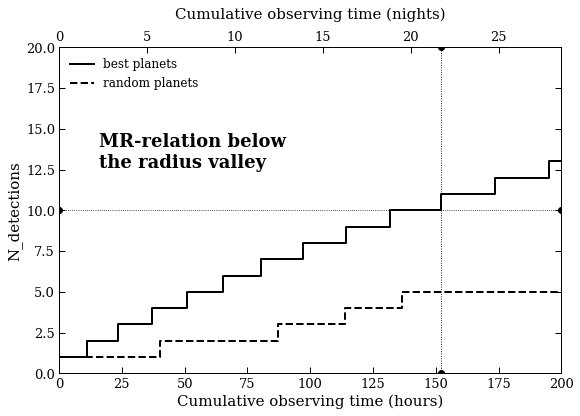

In [11]:
Nf3=10
g = (self.rps_med < 1.5) & (self.decs_med > -15)
tobs = np.append(0, np.cumsum(np.sort(self.tobsGPs_med_N[g]*scale)))
tobs2 = np.append(0, np.cumsum(self.tobsGPs_med_N[g]*scale))
Ndet= np.arange(tobs.size)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.plot(tobs, Ndet, 'k-', lw=2, drawstyle='steps', label='best planets')
ax1.plot(tobs2, Ndet, 'k--', lw=2, drawstyle='steps', label='random planets')
ax1.axhline(Nf3, ls=':', lw=.8), ax1.axvline(tobs[Ndet==Nf3], ls=':', lw=.9)
tobs_WP2 = np.append(tobs_WP2, tobs[Ndet==Nf3])
ax1.set_xlim((0,2e2)), ax1.set_ylim((0,20)), ax1.legend(loc='upper left', fontsize=12)
ax1.set_xlabel('Cumulative observing time (hours)'), ax1.set_ylabel('N_detections')
ax1.text(.08, .63, 'MR-relation below\nthe radius valley', transform=ax1.transAxes, fontsize=18, weight='semibold')
ax2 = ax1.twiny()
ax2.set_xlim((0,2e2/7)), ax2.set_xlabel('Cumulative observing time (nights)', labelpad=12)

In [12]:
inds = np.append(inds, get_planets(self.tobsGPs_med_N, g, Nf3))

## Measuring 5$\sigma$ masses of TOIs amenable to transmission spectroscopy

In [13]:
# set number of WP2 nights available for RV follow-up
transmission_spec_nights = 0
trappist1_nights = 7
total_nights = 100 - transmission_spec_nights - trappist1_nights
tobs_remaining = total_nights*7. - tobs_WP2.sum()

Potential JWST targets must have 

SNR$_{\text{transmission}} \geq 10$, and<br>
$\delta > -15$ deg.

0.025


((0, 14.285714285714286), <matplotlib.text.Text at 0x1a18cd9390>)

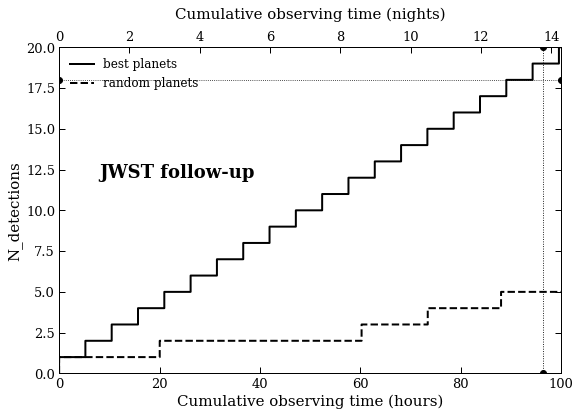

In [14]:
gjwst = (np.in1d(np.arange(self.nstars), inds, invert=True)) & (compute_transmission_SNR(self)[1] >= 10) & (self.decs_med > -15)
tobs = np.append(0, np.cumsum(np.sort(self.tobsGPs_med_N[gjwst]*scale)))
tobs2 = np.append(0, np.cumsum(self.tobsGPs_med_N[gjwst]*scale))
Ndet= np.arange(tobs.size)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.plot(tobs, Ndet, 'k-', lw=2, drawstyle='steps', label='best planets')
ax1.plot(tobs2, Ndet, 'k--', lw=2, drawstyle='steps', label='random planets')
Njwst = int(Ndet[abs(tobs-tobs_remaining) == np.min(abs(tobs-tobs_remaining))])
tobs_WP2 = np.append(tobs_WP2, tobs_remaining)
ax1.axhline(Njwst, ls=':', lw=.8), ax1.axvline(tobs_remaining, ls=':', lw=.9)
ax1.set_xlim((0,np.ceil(tobs_remaining/1e2)*1e2)), ax1.set_ylim((0,np.ceil(Njwst/1e1)*1e1)), ax1.legend(loc='upper left', fontsize=12)
ax1.set_xlabel('Cumulative observing time (hours)'), ax1.set_ylabel('N_detections')
ax1.text(.08, .6, 'JWST follow-up', transform=ax1.transAxes, fontsize=18, weight='semibold')
ax2 = ax1.twiny()
ax2.set_xlim((0,np.ceil(tobs_remaining/1e2)*1e2/7)), ax2.set_xlabel('Cumulative observing time (nights)', labelpad=12)

In [15]:
inds = np.append(inds, get_planets(self.tobsGPs_med_N, gjwst, Njwst))
print 'We detect %i random potential JWST targets in %.1f hours (i.e. %.1f nights)'%(Njwst, tobs_remaining, tobs_remaining/7)

We detect 18 random potential JWST targets in 96.4 hours (i.e. 13.8 nights)


## Summary of WP2 time allocations and planet populations

In [16]:
labels = ['1 temperature Earth-sized planet','%i planets within the radius valley'%Nf1,'%i planets above the radius valley'%Nf2,'%i planets below the radius valley'%Nf3,'%i JWST follow-up planets'%Njwst]
for i in range(tobs_WP2.size):
    print 'Measuring %s requires %.1f hours (i.e. %.1f nights).'%(labels[i], tobs_WP2[i], tobs_WP2[i]/7)
print 'Total observing time for %i TESS targets = %.1f hours (i.e. %.1f nights)'%(inds.size, tobs_WP2.sum(), tobs_WP2.sum()/7.)
print '\nTransmission spectroscopy is allocated %.1f hours (i.e. %.1f nights)'%(transmission_spec_nights*7, transmission_spec_nights)
print 'Monitoring of the TRAPPIST-1 system is allocated %.1f hours (i.e. %.1f nights)'%(trappist1_nights*7, trappist1_nights)
tot_time = tobs_WP2.sum() + (transmission_spec_nights+trappist1_nights)*7
print '\nTotal observing time for WP2 = %.1f hours (i.e. %.1f nights)'%(tot_time, tot_time/7.)

Measuring 1 temperature Earth-sized planet requires 44.2 hours (i.e. 6.3 nights).
Measuring 30 planets within the radius valley requires 305.6 hours (i.e. 43.7 nights).
Measuring 10 planets above the radius valley requires 52.6 hours (i.e. 7.5 nights).
Measuring 10 planets below the radius valley requires 152.3 hours (i.e. 21.8 nights).
Measuring 18 JWST follow-up planets requires 96.4 hours (i.e. 13.8 nights).
Total observing time for 69 TESS targets = 651.0 hours (i.e. 93.0 nights)

Transmission spectroscopy is allocated 0.0 hours (i.e. 0.0 nights)
Monitoring of the TRAPPIST-1 system is allocated 49.0 hours (i.e. 7.0 nights)

Total observing time for WP2 = 700.0 hours (i.e. 100.0 nights)


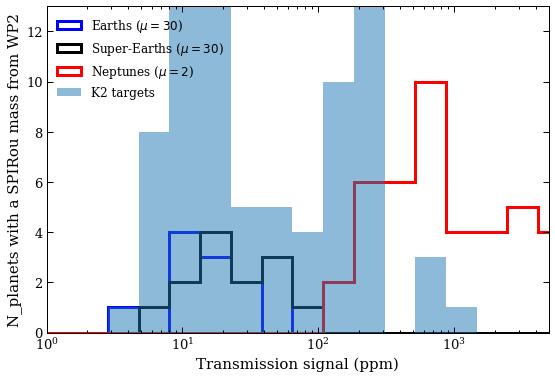

In [17]:
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
g1 = (np.in1d(np.arange(self.nstars), inds)) & (self.rps_med <= 1.5)
ax1.hist(self.transmission_ppm[g1], bins=np.logspace(0,4.3,20), histtype='step', color='b', lw=3, label='Earths ($\mu=30$)')
g3 = (np.in1d(np.arange(self.nstars), inds)) & (self.rps_med <= 2) & (self.rps_med > 1.5)
ax1.hist(self.transmission_ppm[g3], bins=np.logspace(0,4.3,20), histtype='step', color='k', lw=3, label='Super-Earths ($\mu=30$)')
g2 = (np.in1d(np.arange(self.nstars), inds)) & (self.rps_med > 2)
ax1.hist(self.transmission_ppm[g2], bins=np.logspace(0,4.3,20), histtype='step', color='r', lw=3, label='Neptunes ($\mu=2$)')
ax1.hist(transmissionK2_ppm, bins=np.logspace(0,4.3,20), histtype='stepfilled', alpha=.5, label='K2 targets')
ax1.set_xscale('log'), ax1.set_xlim((0,5e3)), ax1.legend(loc='upper left', fontsize=12)
ax1.set_xlabel('Transmission signal (ppm)'), plt.ylabel('N_planets with a SPIRou mass from WP2')
ax1.set_ylim((0,13))

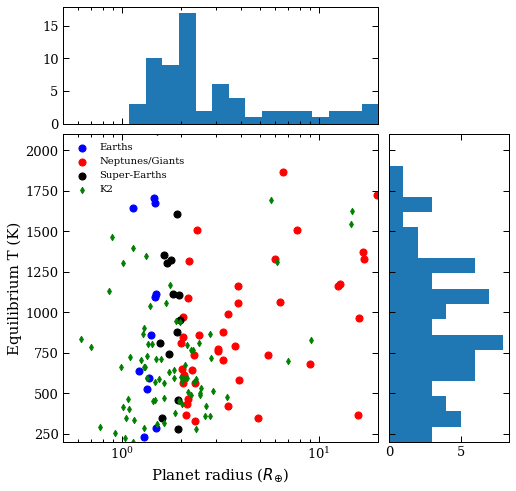

In [18]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(7,7)
ax1 = plt.subplot(gs[2:,:-2])
ax2 = plt.subplot(gs[:2,:-2])
ax3 = plt.subplot(gs[2:,-2:])
ax1.scatter(self.rps_med[g1], self.Tps_med[g1], s=50, c='b', label='Earths'), ax1.set_xlim((.5,20)), ax1.set_ylim((2e2, 2.1e3))
ax1.scatter(self.rps_med[g2], self.Tps_med[g2], s=50, c='r', label='Neptunes/Giants'), ax1.set_xscale('log')
ax1.scatter(self.rps_med[g3], self.Tps_med[g3], s=50, c='k', label='Super-Earths')
ax1.scatter(rpK2, TpK2, s=20, c='g', marker='d', label='K2')
ax1.set_xlabel('Planet radius ($R_{\oplus}$)'), ax1.set_ylabel('Equilibrium T (K)')
ax2.hist(self.rps_med[inds], bins=np.logspace(-.3,np.log10(20),20)), ax2.set_xscale('log'), ax2.set_xlim((.5,20))
ax2.set_xticklabels(''), ax1.legend(loc='upper left')
ax3.hist(self.Tps_med[inds], bins=np.linspace(2e2,2e3,20), orientation='horizontal')
ax3.set_ylim((2e2,2.1e3)), ax3.set_yticklabels('')

(<matplotlib.text.Text at 0x1a10394d50>,
 (0, 11))

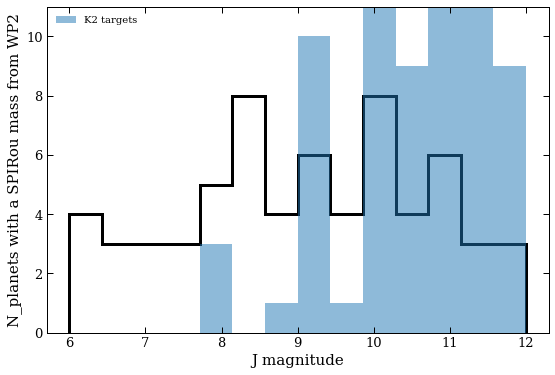

In [19]:
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.hist(self.Jmags_med[inds], bins=np.linspace(6,12,15), histtype='step', color='k', lw=3)
ax1.hist(JK2, bins=np.linspace(6,12,15), histtype='stepfilled', alpha=.5, label='K2 targets')
ax1.legend(loc='upper left')
ax1.set_xlabel('J magnitude'), plt.ylabel('N_planets with a SPIRou mass from WP2'), ax1.set_ylim((0,11))

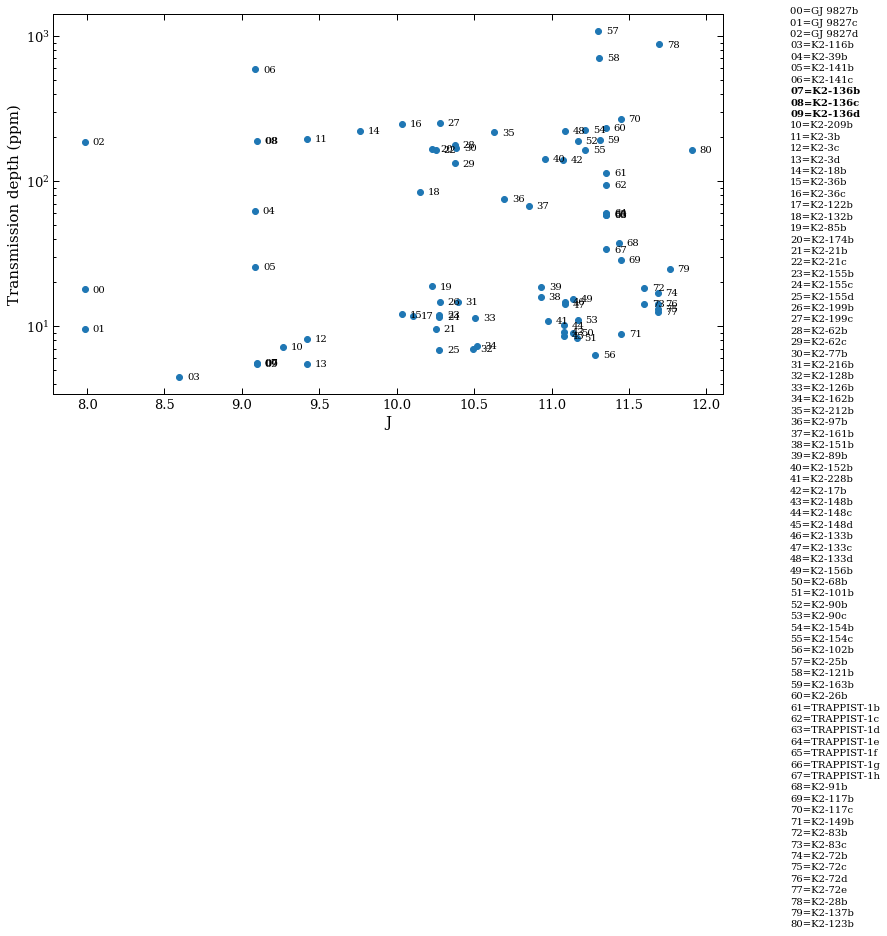

In [20]:
# K2 targets
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.scatter(JK2, transmissionK2_ppm), plt.yscale('log')
ax.set_xlabel('J'), ax.set_ylabel('Transmission depth (ppm)')
labels = np.arange(starnames.size)
for i in range(starnames.size):
    weight = 'bold' if starname[i] == 'K2-136' else 'normal'
    ax.text(JK2[i]+.05, transmissionK2_ppm[i], '%.2d'%labels[i], verticalalignment='center', weight=weight)
    ax.text(1.1, 1-.03*i, '%.2d=%s'%(labels[i], starnames[i]), transform=ax.transAxes, weight=weight)

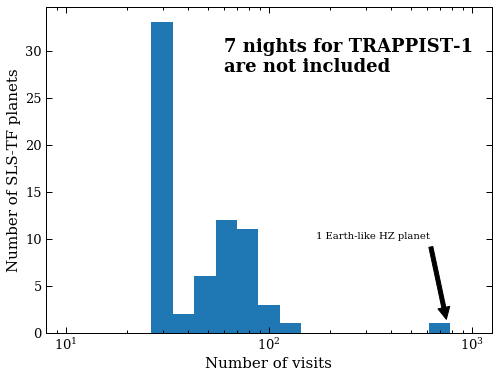

In [21]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.hist(self.NrvGPs_med_N[inds]*scale, bins=np.logspace(1,3,20)), plt.xscale('log')
ax1.set_ylabel('Number of SLS-TF planets'), ax1.set_xlabel('Number of visits')
ax1.annotate('1 Earth-like HZ planet', xy=(self.NrvGPs_med_N[ind]*scale,1), xytext=(170,10), arrowprops=dict(facecolor='black', shrink=0.05))
ax1.text(.4, .8, '%i nights for TRAPPIST-1\nare not included'%trappist1_nights, transform=ax1.transAxes, fontsize=18, weight='semibold')

In [22]:
print 'Median N_RV for the WP2 sample is %.1f'%np.median(self.NrvGPs_med_N[inds]*scale)
print 'Average N_RV for the WP2 sample is %.1f'%np.mean(self.NrvGPs_med_N[inds]*scale)

Median N_RV for the WP2 sample is 41.4
Average N_RV for the WP2 sample is 59.7


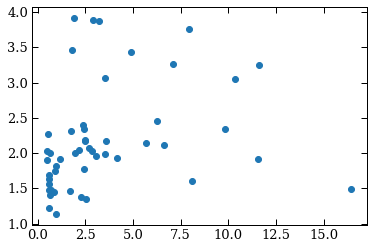

In [40]:
mrinds = inds[1:51]
plt.scatter(self.Ps_med[mrinds], self.rps_med[mrinds])

(array([ 2.,  3.,  5.,  3.,  4.,  5.,  7.,  5.,  4.,  2.,  0.,  0.,  0.,
         2.,  0.,  2.,  2.,  0.,  1.,  3.]),
 array([ 1.137 ,  1.2758,  1.4146,  1.5534,  1.6922,  1.831 ,  1.9698,
         2.1086,  2.2474,  2.3862,  2.525 ,  2.6638,  2.8026,  2.9414,
         3.0802,  3.219 ,  3.3578,  3.4966,  3.6354,  3.7742,  3.913 ]),
 <a list of 20 Patch objects>)

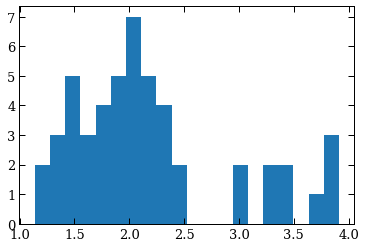

In [43]:
plt.hist(self.rps_med[mrinds], bins=20)